In [1]:
import numpy as np
import os

# DataFrames
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib


# 1. Préparation des données

### a. Import du dataset et inspection rapide

In [2]:
df = pd.read_csv("../data/lille_2022.csv")

In [3]:
df.head()

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,prix_m2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,0,1.0,Maison,NaN,82.0,5.0,S,NaN,70.0,2681.707317
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,2,2.0,Appartement,NaN,63.0,3.0,NaN,NaN,NaN,2936.507937
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,2,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,inf
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,inf
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,inf


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11354 entries, 0 to 11353
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Identifiant de document     0 non-null      float64
 1   Reference document          0 non-null      float64
 2   1 Articles CGI              0 non-null      float64
 3   2 Articles CGI              0 non-null      float64
 4   3 Articles CGI              0 non-null      float64
 5   4 Articles CGI              0 non-null      float64
 6   5 Articles CGI              0 non-null      float64
 7   No disposition              11354 non-null  int64  
 8   Date mutation               11354 non-null  object 
 9   Nature mutation             11354 non-null  object 
 10  Valeur fonciere             11354 non-null  float64
 11  No voie                     11248 non-null  float64
 12  B/T/Q                       652 non-null    object 
 13  Type de voie                113

### b. Filtre des biens de 4 pièces uniquement

In [42]:
df = df[df["Nombre pieces principales"] == 4.0]

### c. Création de datasets spécifiques maisons / appartements

In [6]:
df_maisons = df[df["Type local"] == "Maison"]

In [7]:
df_appartements = df[df["Type local"] == "Appartement"]

### d. Sélection des colonnes utiles

In [8]:
colonnes_utiles = ["Surface reelle bati", "Nombre pieces principales", "Type local", "Surface terrain", "Nombre de lots", "Valeur fonciere", "prix_m2"]

df_maisons = df_maisons[colonnes_utiles]
df_appartements = df_appartements[colonnes_utiles]

### e. Vérification des données

In [9]:
df_maisons.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
18,165.0,4.0,Maison,121.0,0,305000.0,1848.484848
65,64.0,4.0,Maison,127.0,0,226900.0,3545.312500
161,70.0,4.0,Maison,192.0,0,205890.0,2941.285714
168,62.0,4.0,Maison,96.0,0,159500.0,2572.580645
176,72.0,4.0,Maison,135.0,0,259900.0,3609.722222


In [10]:
df_maisons.shape

(354, 7)

In [11]:
df_maisons.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,354.000000,354.0,340.000000,354.000000,354.000000,354.000000
mean,84.310734,4.0,142.638235,0.039548,251205.864379,3003.594635
std,19.462888,0.0,84.800103,0.195171,105865.398518,1116.900260
min,44.000000,4.0,31.000000,0.000000,16000.000000,144.144144
25%,71.000000,4.0,84.750000,0.000000,185032.500000,2291.390977
50%,80.500000,4.0,127.000000,0.000000,237550.000000,2847.948718
75%,95.000000,4.0,175.250000,0.000000,290000.000000,3481.995492
max,165.000000,4.0,607.000000,1.000000,753750.000000,9192.073171


In [12]:
df_appartements.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
23,92.0,4.0,Appartement,NaN,1,367000.0,3989.130435
26,70.0,4.0,Appartement,NaN,2,170000.0,2428.571429
58,105.0,4.0,Appartement,NaN,2,355300.0,3383.809524
62,120.0,4.0,Appartement,NaN,1,472500.0,3937.500000
113,71.0,4.0,Appartement,NaN,1,229900.0,3238.028169


In [13]:
df_appartements.shape

(435, 7)

In [14]:
df_appartements.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,435.000000,435.0,49.000000,435.000000,4.350000e+02,435.000000
mean,90.450575,4.0,232.714286,1.434483,4.516911e+05,4989.066032
std,23.340679,0.0,193.109533,0.865204,6.368548e+05,7087.899307
min,18.000000,4.0,43.000000,0.000000,1.000000e+00,0.011494
25%,77.000000,4.0,136.000000,1.000000,2.150000e+05,2617.078231
50%,85.000000,4.0,176.000000,1.000000,2.850000e+05,3285.714286
75%,99.000000,4.0,306.000000,2.000000,4.297500e+05,4310.382231
max,215.000000,4.0,1207.000000,8.000000,4.738000e+06,52065.934066


Nous pouvons voir que sur 435 appartements, 49 ont une information Surface terrain (nous pouvons supposer que seuls 49 appartement possédaient un terrain à la vente). Il faudra donc traiter cette information intelligemment :  
- Supprimer la colonne car cela ne représente que 10-11% des appartements, et donc peu pertinente voire aberrante parfois.
- Garder la colonne mais la transformer en variable binaire (possède un terrain ou non)
- Garder la colonne telle quelle avec une valeur a 0 pour ceux ne possèdant pas de terrain

Ici je décide de supprimer la colonne car même si l'information pouvait être précieuse, elle ne représente que peu de cas, et cela va éviter d'introduire du bruit pour le modèle.

### f. Traitement des données

Maison : Remplacement des valeurs manquantes par la médiane

In [15]:
df_maisons["Surface terrain"] = df_maisons["Surface terrain"].fillna(df_maisons["Surface terrain"].median())

In [16]:
df_maisons.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,354.000000,354.0,354.000000,354.000000,354.000000,354.000000
mean,84.310734,4.0,142.019774,0.039548,251205.864379,3003.594635
std,19.462888,0.0,83.157533,0.195171,105865.398518,1116.900260
min,44.000000,4.0,31.000000,0.000000,16000.000000,144.144144
25%,71.000000,4.0,87.250000,0.000000,185032.500000,2291.390977
50%,80.500000,4.0,127.000000,0.000000,237550.000000,2847.948718
75%,95.000000,4.0,172.750000,0.000000,290000.000000,3481.995492
max,165.000000,4.0,607.000000,1.000000,753750.000000,9192.073171


Appartements : suppression de la colonne Surface terrain

In [17]:
df_appartements = df_appartements.drop(columns=["Surface terrain"])

In [18]:
df_appartements.describe()

,Surface reelle bati,Nombre pieces principales,Nombre de lots,Valeur fonciere,prix_m2
count,435.000000,435.0,435.000000,4.350000e+02,435.000000
mean,90.450575,4.0,1.434483,4.516911e+05,4989.066032
std,23.340679,0.0,0.865204,6.368548e+05,7087.899307
min,18.000000,4.0,0.000000,1.000000e+00,0.011494
25%,77.000000,4.0,1.000000,2.150000e+05,2617.078231
50%,85.000000,4.0,1.000000,2.850000e+05,3285.714286
75%,99.000000,4.0,2.000000,4.297500e+05,4310.382231
max,215.000000,4.0,8.000000,4.738000e+06,52065.934066


# 2. Analyses univariées / bivariées

### a. Relations des features avec la target (prix_m2)

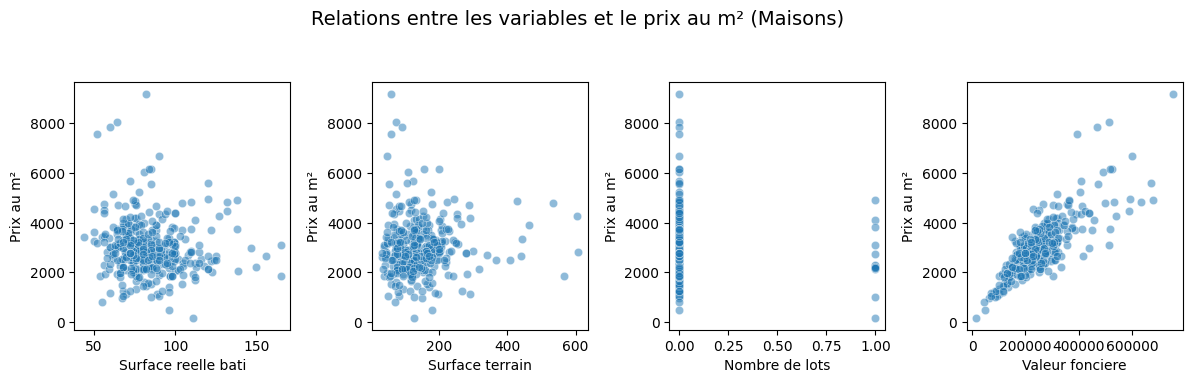

In [19]:
cols = df_maisons.columns.drop(["Type local", "Nombre pieces principales", "prix_m2"])

plt.figure(figsize=(15, 15))

for i, col in enumerate(cols, 1):
    plt.subplot(5, 5, i)
    sns.scatterplot(data=df_maisons, x=col, y="prix_m2", alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Prix au m²")

plt.tight_layout()
plt.title("Relations entre les variables et le prix au m² (Maisons)", fontsize=14, x=-1.8, y=1.2)
plt.show()

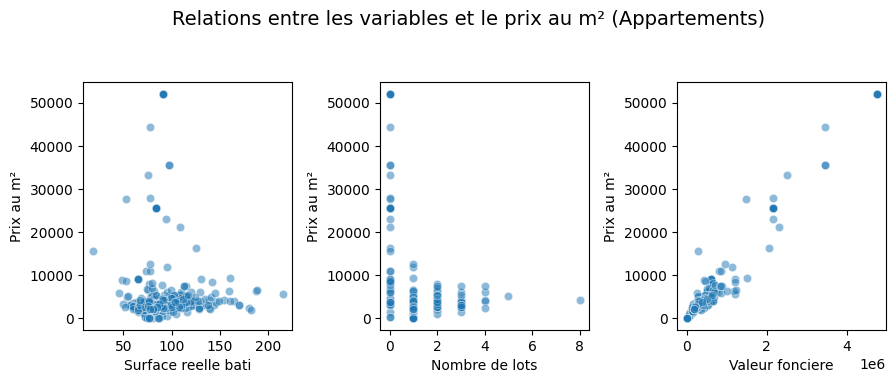

In [20]:
cols = df_appartements.columns.drop(["Type local", "Nombre pieces principales", "prix_m2"])

plt.figure(figsize=(15, 15))

for i, col in enumerate(cols, 1):
    plt.subplot(5, 5, i)
    sns.scatterplot(data=df_appartements, x=col, y="prix_m2", alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Prix au m²")

plt.tight_layout()
plt.title("Relations entre les variables et le prix au m² (Appartements)", fontsize=14, x=-1.0, y=1.2)
plt.show()

### b. Matrices de corrélations

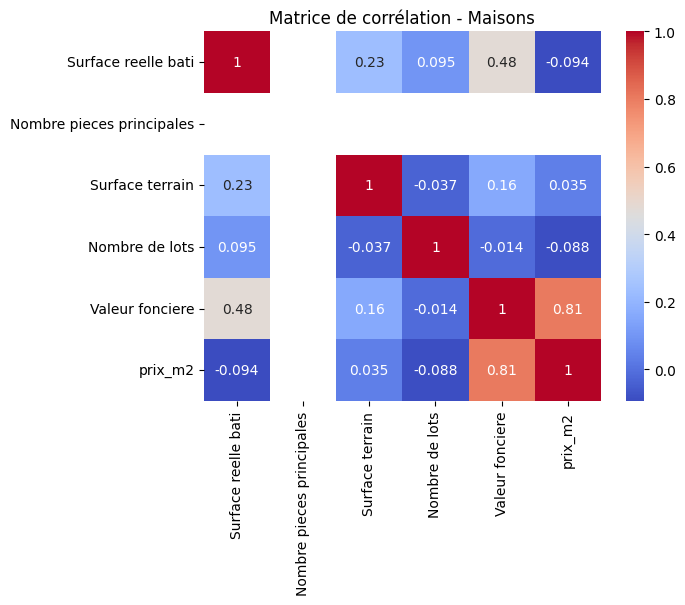

In [21]:
df_numeriques = df_maisons.select_dtypes(include=["int", "float"])

sns.heatmap(df_numeriques.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation - Maisons")
plt.show()

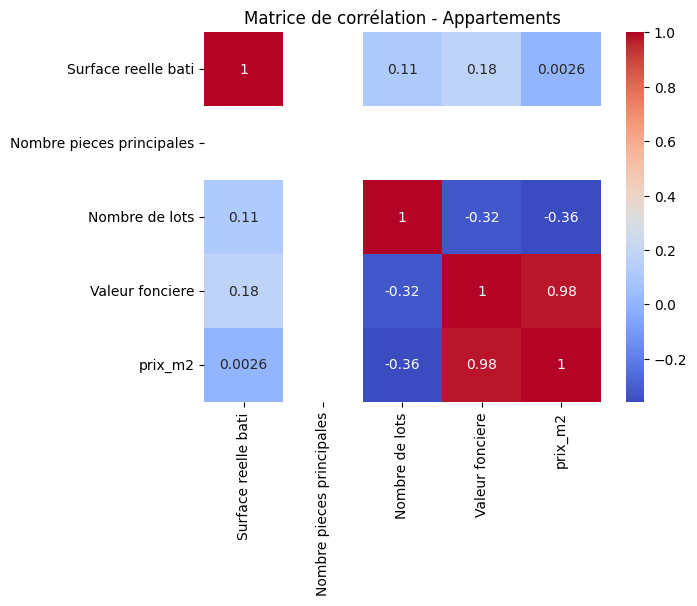

In [22]:
df_numeriques = df_appartements.select_dtypes(include=["int", "float"])

sns.heatmap(df_numeriques.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation - Appartements")
plt.show()

### c. Boxplots

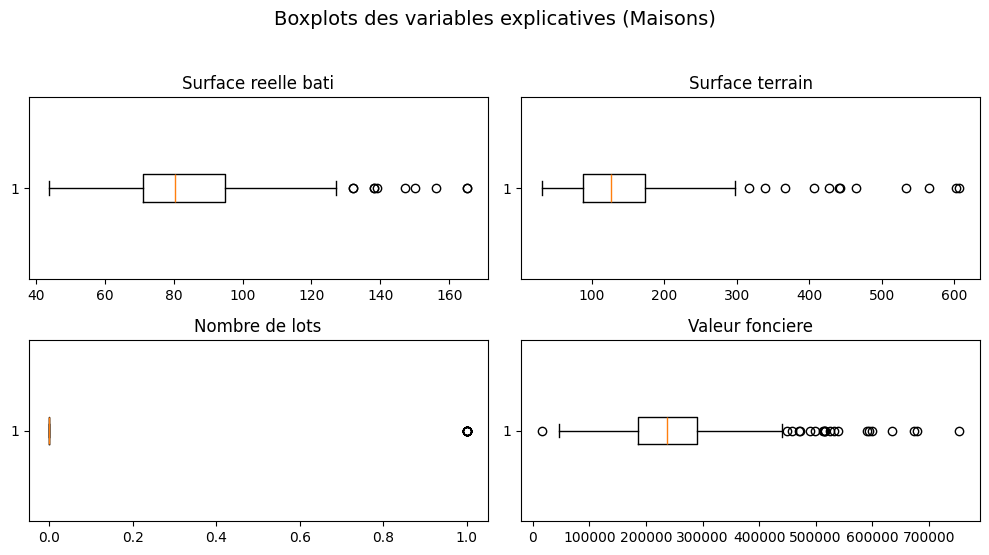

In [23]:
# On retire la target (valeur_m2) si elle est dans les colonnes
features = df_maisons.drop(columns=["Type local", "Nombre pieces principales", "prix_m2"]).select_dtypes(include='number').columns

# Taille de la grille (adapter selon ton nombre de features)
n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(10, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(x=df_maisons[feature], vert=False)
    plt.title(f"{feature}")
    plt.xlabel("")  # Optionnel : masque l'axe x si c'est surchargé

plt.tight_layout()
plt.suptitle("Boxplots des variables explicatives (Maisons)", fontsize=14, y=1.1)
plt.show()

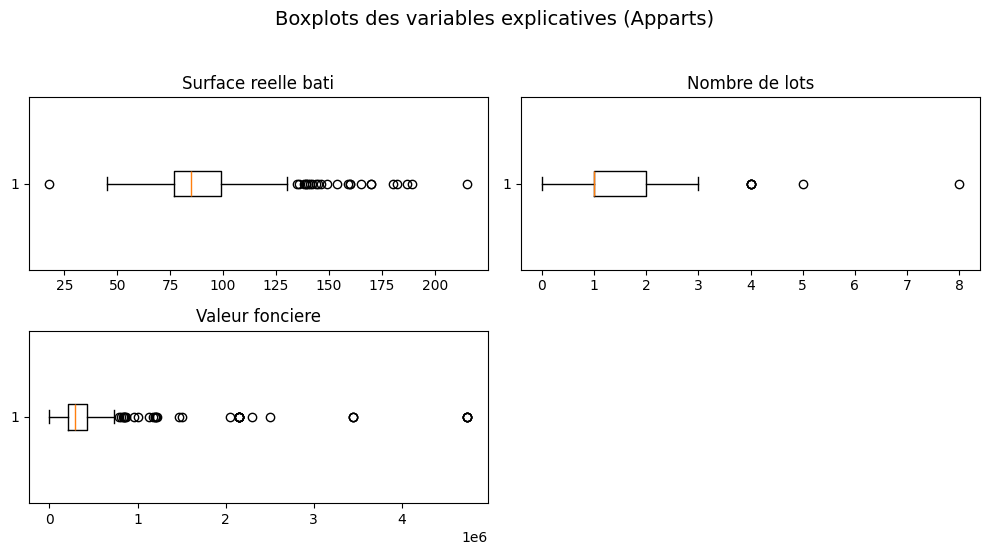

In [ ]:
# On retire la target (valeur_m2) si elle est dans les colonnes
features = df_appartements.drop(columns=["Type local", "Nombre pieces principales", "prix_m2"]).select_dtypes(include='number').columns

# Taille de la grille
n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(10, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(x=df_appartements[feature], vert=False)
    plt.title(f"{feature}")
    plt.xlabel("")  # Optionnel : masque l'axe x si c'est surchargé

plt.tight_layout()
plt.suptitle("Boxplots des variables explicatives (Apparts)", fontsize=14, y=1.1)
plt.show()

# 3. Data preparation

### a. Gestion des outliers

In [25]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (
        lower_bound, 
        upper_bound, 
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        )

Pour les maisons :

In [ ]:
print("Surface reelle bati :")
display(detect_outliers(df_maisons, "Surface reelle bati")[2])

print("Outliers Surface terrain :")
display(detect_outliers(df_maisons, "Surface terrain")[2])

print("Outliers Nombre de lots :")
display(detect_outliers(df_maisons, "Nombre de lots")[2])

print("Outliers Valeur fonciere :")
display(detect_outliers(df_maisons, "Valeur fonciere")[2])

print("Outliers prix_m2 :")
display(detect_outliers(df_maisons, "prix_m2")[2])

In [27]:
lower_bound, upper_bound, _ = detect_outliers(df_maisons, "Surface reelle bati")
df_maisons = df_maisons[~((df_maisons["Surface reelle bati"] < lower_bound) | (df_maisons["Surface reelle bati"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_maisons, "Surface terrain")
df_maisons = df_maisons[~((df_maisons["Surface terrain"] < lower_bound) | (df_maisons["Surface terrain"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_maisons, "Valeur fonciere")
df_maisons = df_maisons[~((df_maisons["Valeur fonciere"] < lower_bound) | (df_maisons["Valeur fonciere"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_maisons, "prix_m2")
df_maisons = df_maisons[~((df_maisons["prix_m2"] < lower_bound) | (df_maisons["prix_m2"] > upper_bound))]

In [28]:
df_maisons.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,309.000000,309.0,309.000000,309.000000,309.000000,309.000000
mean,81.207120,4.0,131.822006,0.035599,226767.332330,2819.105933
std,15.290981,0.0,56.961972,0.185588,68813.348364,790.061211
min,44.000000,4.0,31.000000,0.000000,45381.780000,825.123273
25%,70.000000,4.0,87.000000,0.000000,181500.000000,2254.237288
50%,80.000000,4.0,127.000000,0.000000,226900.000000,2811.594203
75%,91.000000,4.0,169.000000,0.000000,267800.000000,3294.117647
max,123.000000,4.0,298.000000,1.000000,425000.000000,4751.250000


Pour les appartements :

In [ ]:
print("Surface reelle bati :")
display(detect_outliers(df_appartements, "Surface reelle bati")[2])

print("Outliers Nombre de lots :")
display(detect_outliers(df_appartements, "Nombre de lots")[2])

print("Outliers Valeur fonciere :")
display(detect_outliers(df_appartements, "Valeur fonciere")[2])

print("Outliers prix_m2 :")
display(detect_outliers(df_appartements, "prix_m2")[2])

In [30]:
lower_bound, upper_bound, _ = detect_outliers(df_appartements, "Surface reelle bati")
df_appartements = df_appartements[~((df_appartements["Surface reelle bati"] < lower_bound) | (df_appartements["Surface reelle bati"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_appartements, "Nombre de lots")
df_appartements = df_appartements[~((df_appartements["Nombre de lots"] < lower_bound) | (df_appartements["Nombre de lots"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_appartements, "Valeur fonciere")
df_appartements = df_appartements[~((df_appartements["Valeur fonciere"] < lower_bound) | (df_appartements["Valeur fonciere"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_appartements, "prix_m2")
df_appartements = df_appartements[~((df_appartements["prix_m2"] < lower_bound) | (df_appartements["prix_m2"] > upper_bound))]

In [31]:
df_appartements.describe()

,Surface reelle bati,Nombre pieces principales,Nombre de lots,Valeur fonciere,prix_m2
count,350.00000,350.0,350.000000,350.000000,350.000000
mean,86.96000,4.0,1.525714,285920.916543,3244.027650
std,15.78286,0.0,0.617947,111125.158530,937.860212
min,49.00000,4.0,0.000000,50500.000000,557.894737
25%,77.25000,4.0,1.000000,208375.000000,2591.240642
50%,84.50000,4.0,2.000000,267865.000000,3131.869369
75%,96.00000,4.0,2.000000,345000.000000,3837.571922
max,130.00000,4.0,3.000000,627000.000000,5538.043478


### b. Colonnes et train / test split

In [32]:
# Pour les maisons
X_maisons = df_maisons[["Surface reelle bati", "Nombre de lots", "Surface terrain", "Nombre pieces principales"]]
y_maisons = df_maisons["prix_m2"]

# Pour les appartements
X_appartements = df_appartements[["Surface reelle bati", "Nombre de lots", "Nombre pieces principales"]]
y_appartements = df_appartements["prix_m2"]

In [33]:
# Pour les maisons
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_maisons, y_maisons, test_size=0.2, random_state=42
)

# Pour les appartements
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_appartements, y_appartements, test_size=0.2, random_state=42
)

In [34]:
print("Maisons :", X_train_m.shape, X_test_m.shape)
print("Appartements :", X_train_a.shape, X_test_a.shape)

Maisons : (247, 4) (62, 4)
Appartements : (280, 3) (70, 3)


# 4. Pipeline de modélisation supervisée

In [35]:
def train_with_pipelines(X_train, y_train, X_test, y_test):

    models = {
        "Régression Linéaire": {
            "estimator": LinearRegression(),
            "params": None  # Pas de grid search ici
        },
        "Arbre de Décision": {
            "estimator": DecisionTreeRegressor(random_state=42),
            "params": {
                'regressor__max_depth': [5, 10, 20]
            }
        },
        "Forêt Aléatoire": {
            "estimator": RandomForestRegressor(random_state=42),
            "params": {
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [10, 20]
            }
        },
        "XGBRegressor": {
            "estimator": XGBRegressor(random_state=42, verbosity=0),
            "params": {
                'regressor__n_estimators': [100, 200],
                'regressor__learning_rate': [0.05, 0.1],
                'regressor__max_depth': [3, 5]
            }
        }
    }

    resultats = {}

    for nom, contenu in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', contenu["estimator"])
        ])

        if contenu["params"]:
            model = GridSearchCV(pipeline, contenu["params"], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        else:
            model = pipeline

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        resultats[nom] = {
            "pipeline": model.best_estimator_ if hasattr(model, "best_estimator_") else model,
            "MSE": round(mse, 2),
            "RMSE": round(rmse, 2),
            "R2": round(r2, 4),
        }

    return resultats

Application pour les maisons :

In [36]:
resultats_maisons = train_with_pipelines(X_train_m, y_train_m, X_test_m, y_test_m)

In [37]:
for modele, metriques in resultats_maisons.items():
    print(f"[Maisons] {modele} => MSE: {metriques['MSE']}, RMSE: {metriques['RMSE']}, R2: {metriques['R2']}")

[Maisons] Régression Linéaire => MSE: 661260.65, RMSE: 813.18, R2: 0.0774
[Maisons] Arbre de Décision => MSE: 733919.58, RMSE: 856.69, R2: -0.024
[Maisons] Forêt Aléatoire => MSE: 613361.23, RMSE: 783.17, R2: 0.1442
[Maisons] XGBRegressor => MSE: 673514.24, RMSE: 820.68, R2: 0.0603


Application pour les appartements :

In [38]:
resultats_apparts = train_with_pipelines(X_train_a, y_train_a, X_test_a, y_test_a)

In [39]:
for modele, metriques in resultats_apparts.items():
    print(f"[Appartements] {modele} => MSE: {metriques['MSE']}, RMSE: {metriques['RMSE']}, R2: {metriques['R2']}")

[Appartements] Régression Linéaire => MSE: 655349.56, RMSE: 809.54, R2: 0.067
[Appartements] Arbre de Décision => MSE: 608918.45, RMSE: 780.33, R2: 0.1331
[Appartements] Forêt Aléatoire => MSE: 808486.27, RMSE: 899.16, R2: -0.1511
[Appartements] XGBRegressor => MSE: 659542.86, RMSE: 812.12, R2: 0.061


# 5. Comparatif des performances des modèles

In [40]:
comparatif = pd.DataFrame({
    "Modèle": [],
    "MSE Maisons": [],
    "RMSE Maisons": [],
    "R2 Maisons": [],
    "MSE Appartements": [],
    "RMSE Appartements": [],
    "R2 Appartements": []
})

for modele in resultats_maisons.keys():
    comparatif = pd.concat([comparatif, pd.DataFrame({
        "Modèle": [modele],
        "MSE Maisons": [resultats_maisons[modele]["MSE"]],
        "RMSE Maisons": [resultats_maisons[modele]["RMSE"]],
        "R2 Maisons": [resultats_maisons[modele]["R2"]],
        "MSE Appartements": [resultats_apparts[modele]["MSE"]],
        "RMSE Appartements": [resultats_apparts[modele]["RMSE"]],
        "R2 Appartements": [resultats_apparts[modele]["R2"]]
    })], ignore_index=True)

display(comparatif)

,Modèle,MSE Maisons,RMSE Maisons,R2 Maisons,MSE Appartements,RMSE Appartements,R2 Appartements
0,Régression Linéaire,661260.65,813.18,0.0774,655349.56,809.54,0.0670
1,Arbre de Décision,733919.58,856.69,-0.0240,608918.45,780.33,0.1331
2,Forêt Aléatoire,613361.23,783.17,0.1442,808486.27,899.16,-0.1511
3,XGBRegressor,673514.24,820.68,0.0603,659542.86,812.12,0.0610


# 6. Enregistrement des modèles :

In [41]:
joblib.dump(resultats_maisons, "../models/modeles_maisons.joblib")
joblib.dump(resultats_apparts, "../models/modeles_apparts.joblib")

['../models/modeles_apparts.joblib']